In [1]:
# check the EVs battery capacities
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from vehicles import *

#import sys
#sys.path.append('/Users/dpelleg/miniconda/lib/python3.10/site-packages')

from statsmodels.stats.proportion import proportions_ztest

# do I need this? how to persist the change in path?


In [2]:
datadir = '../data/may2025/'

In [3]:
def read_file(fname, enc='iso8859-8'):
    fd = open(fname, encoding=enc, errors='replace')
    df = pd.read_csv(fd, sep='|')
    return df

def add_model(df):
    df['model'] = df.apply(lambda x: '_'.join([x[y] for y in ['tozeret_cd', 'degem_cd', 'shnat_yitzur', 'sug_degem']]), axis=1)

def get_model_name(ns):
    names = pd.DataFrame(data={'model':ns})
    ret = pd.merge(names, models, how='left', on='model')[['tozeret_nm', 'kinuy_mishari']]
    return ret

def ztest_proportions(df, population, test):
    xtab=pd.crosstab(df[population], df[test])
    se, pval = proportions_ztest(xtab[True].to_list(), xtab.sum(axis=1).to_list())
    return pval

In [4]:
# source : https://data.gov.il/dataset/private-and-commercial-vehicles/resource/053cea08-09bc-40ec-8f7a-156f0677aff3?inner_span=True

#df = pd.read_csv('data/rechev-small.csv', encoding='iso-8859-1', sep='|')
cars = read_file(datadir + 'rechev.csv')

stringify_cols(cars)
#for c in ['mispar_rechev', 'degem_cd', 'tozeret_cd', 'shnat_yitzur']:
#    cars[c] = cars[c].astype(str)

cars['time'] = pd.to_datetime(cars['moed_aliya_lakvish'], format='%Y-%m').dt.strftime('%Y-%m')

In [5]:
elec_cars_all = cars.query("sug_delek_nm == 'חשמל'").copy()
capacities = pd.read_csv('../data/capacities.csv')


In [6]:
elec_cars = elec_cars_all.merge(right=capacities, left_on='kinuy_mishari', right_on='model', how='left', indicator=True)

In [7]:
unknown_models = elec_cars[elec_cars['_merge'] == 'left_only']
missing_rate = len(unknown_models) / len(elec_cars_all)
if missing_rate > 0.05:
    print(f"Warning: {missing_rate*100:.0f}% of electric vehicles are missing battery capacities.")
    # Most common missing manufacturers
    print("\nTop 10 models missing from the capacities file:")
    print(unknown_models[['tozeret_nm', 'kinuy_mishari']].value_counts().head(10))


Top 10 models missing from the capacities file:
tozeret_nm     kinuy_mishari
מ.ג סין        MG5              995
פיאט איטליה    FIAT 500         983
סמארט סין      HASHTAG ONE      970
יונדאי קוריאה  GENESIS  GV60    863
קיה קוריאה     EV6              836
וולבו סין      EX30 SM          783
אאודי          Q4 SPORTBACK     752
ליפמוטור סין   T03              745
דונגפנג סין    BOX              719
סרס סין        SERES M5         674
dtype: int64


In [8]:
elec_cars = elec_cars.query('_merge == "both"')
power_counts = pd.DataFrame(elec_cars[['max_power', 'capacity']].value_counts().sort_index().reset_index())
power_counts.columns = ['max_power', 'capacity', 'count']

In [9]:
elec_cars[['make', 'kinuy_mishari']].value_counts(normalize=True).reset_index()

,make,kinuy_mishari,0
0,BYD,ATTO 3,0.207659
1,Geely,GEOMETRY C,0.128793
2,Tesla,MODEL 3,0.111855
3,Tesla,MODEL Y,0.065130
4,Chery,FX EV,0.043248
5,MG,MG4,0.040404
6,Hyundai,IONIQ5,0.040301
7,BYD,BYD DOLPHIN,0.034689
8,Xpeng,G6,0.033794
9,MG,ZS EV,0.033346


In [10]:
power_counts.to_csv(datadir + 'power_counts.csv', index=False)
print(len(elec_cars))

145233


In [11]:
power_counts_23 = pd.read_csv('../data/apr2023/power_counts.csv')
power_counts_24 = pd.read_csv('../data/dec2024/power_counts.csv')
power_counts_25 = pd.read_csv('../data/may2025/power_counts.csv')

In [12]:
def show_stats(df, col='max_power'):
    all_vals = np.repeat(df[col].to_list(), df['count'].to_list())
    s = pd.Series(all_vals)
    print(s.describe())

print(show_stats(power_counts_23))
print(show_stats(power_counts_24))
print(show_stats(power_counts_25))

    

count    34567.000000
mean       133.305002
std         56.020356
min         46.000000
25%         86.000000
50%        125.000000
75%        160.000000
max        250.000000
dtype: float64
None
count    100704.000000
mean        131.956576
std          62.021856
min          46.000000
25%          86.000000
50%          92.000000
75%         160.000000
max         300.000000
dtype: float64
None
count    137886.000000
mean        126.340723
std          64.155069
min          46.000000
25%          80.000000
50%          86.000000
75%         160.000000
max         318.000000
dtype: float64
None


In [13]:
print(show_stats(power_counts_23, col='capacity'))
print(show_stats(power_counts_24, col='capacity'))


count    34567.000000
mean        62.333494
std          8.551901
min         50.000000
25%         58.000000
50%         59.000000
75%         63.100000
max         90.000000
dtype: float64
None
count    100704.000000
mean         63.157963
std           9.004179
min          50.000000
25%          58.000000
50%          59.000000
75%          64.000000
max          92.000000
dtype: float64
None


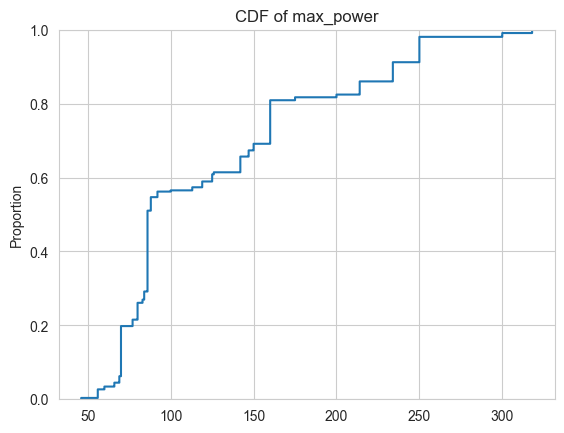

In [14]:
import numpy as np
all_max_powers = np.repeat(power_counts['max_power'].to_list(), power_counts['count'].to_list())
sns.ecdfplot(all_max_powers)
plt.title('CDF of max_power')
plt.show()

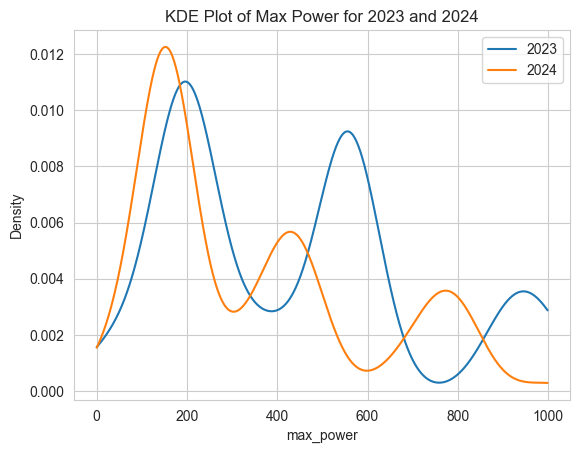

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

def kde_plot_from_dfs(df1: pd.DataFrame, df2: pd.DataFrame, names, x_col: str, title: str = None, bw_adjust: float = 1.0, cap: float = 300.0):
    """
    Generate a Kernel Density Estimation (KDE) plot from two DataFrames.

    Parameters:
    - df1 (pd.DataFrame): The first DataFrame containing values and their counts.
    - df2 (pd.DataFrame): The second DataFrame containing values and their counts.
    - x_col (str): The name of the column containing the values.
    - title (str, optional): The title for the plot. Defaults to None.
    - bw_adjust (float, optional): The bandwidth adjustment factor. Defaults to 1.0.
    - cap (float, optional): The maximum value to cap the KDE plot. Defaults to 300.0.

    Returns:
    - None
    """
    # Extract the values and their counts for both dataframes
    values1 = df1[x_col].to_list()
    counts1 = df1['count'].to_list()
    values2 = df2[x_col].to_list()
    counts2 = df2['count'].to_list()

    # Create numpy arrays with repeated values based on their counts
    all_values1 = np.repeat(values1, counts1)
    all_values2 = np.repeat(values2, counts2)

    # Create Gaussian KDE objects with the specified bandwidth adjustment
    kde1 = gaussian_kde(all_values1, bw_method=bw_adjust)
    kde2 = gaussian_kde(all_values2, bw_method=bw_adjust)

    # Create the figure and plot the KDEs
    fig, ax = plt.subplots()
    ax.plot(kde1.evaluate(np.linspace(min(all_values1), min(cap, max(all_values1)), 1000)), label=names[0])
    ax.plot(kde2.evaluate(np.linspace(min(all_values2), min(cap, max(all_values2)), 1000)), label=names[1])

    # Add a title if provided
    if title:
        ax.set_title(title)

    # Set labels, legend, and show the plot
    ax.set_xlabel(x_col)
    ax.set(ylabel='Density')
    ax.legend()
    plt.show()

# Example usage
kde_plot_from_dfs(power_counts_23, power_counts_24, ['2023', '2024'], 'max_power', 'KDE Plot of Max Power for 2023 and 2024', bw_adjust=0.25, cap=300)

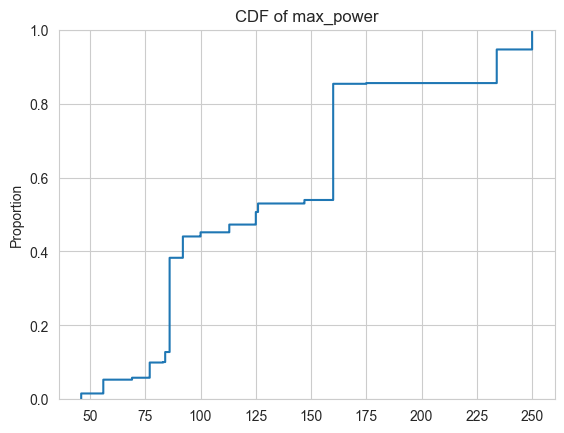

In [16]:
all_max_powers = np.repeat(power_counts_23['max_power'].to_list(), power_counts_23['count'].to_list())
sns.ecdfplot(all_max_powers)
plt.title('CDF of max_power')
plt.show()

In [17]:
elec_cars.query("time == '2025-04'")['kinuy_mishari'].value_counts()

MG4           549
ATTO 3        329
G6            221
FX EV         217
GEOMETRY C    180
LYNKCO 02     145
P7I            85
IONIQ5         76
ZEEKR X        57
ZEEKR 001      53
MODEL 3        52
SEAL           41
SEAL U         39
G9             25
ET5            25
LIMO           10
IONIQ6          6
Name: kinuy_mishari, dtype: int64

In [38]:
import numpy as np
def median_non_nan(x):
    return np.nanmedian(x)

def percentile_25(x):
    return np.nanpercentile(x, 25)

def percentile_75(x):
    return np.nanpercentile(x, 75)

elec_capacity = elec_cars.query("time > '2020-01'").groupby('time').agg({
    'capacity': ['mean', percentile_25, percentile_75, 'size', 'sum'],
    'max_power': ['mean', percentile_25, percentile_75, 'size', 'sum'],
})

# Rename columns for clarity
elec_capacity.columns = ['mean_capacity', 'capacity_25th', 'capacity_75th', 'size_capacity', 'total_capacity',
                         'mean_max_power', 'max_power_25th', 'max_power_75th', 'size_max_power', 'total_max_power',]


In [39]:
tot_bat_capacity = elec_capacity.sum().total_capacity/10**6
daily_utilization = (0.3)*tot_bat_capacity
hourly_power = daily_utilization/24
annual_energy = 365*daily_utilization
print(f"{tot_bat_capacity}, {daily_utilization}, {hourly_power}, {annual_energy}")

9.20671705, 2.762015115, 0.11508396312500001, 1008.135516975


In [40]:
elec_capacity

,mean_capacity,capacity_25th,capacity_75th,size_capacity,total_capacity,mean_max_power,max_power_25th,max_power_75th,size_max_power,total_max_power
time,,,,,,,,,,
2020-02,55.774790,50.3,52.525,119,6637.20,100.928571,84.0,126.0,119,2826.0
2020-03,55.117890,50.3,55.000,109,6007.85,61.111111,46.0,84.0,109,2200.0
2020-04,52.566667,50.3,54.750,18,946.20,46.000000,46.0,46.0,18,138.0
2020-05,55.051020,50.3,54.750,49,2697.50,115.500000,115.5,126.0,49,924.0
2020-06,57.691848,50.3,64.000,92,5307.65,104.512821,84.0,126.0,92,4076.0
...,...,...,...,...,...,...,...,...,...,...
2024-12,68.693636,57.5,92.000,3944,270927.70,187.818367,160.0,250.0,3944,738314.0
2025-01,84.141633,58.0,92.000,5940,499801.30,128.557235,80.0,200.0,5940,756945.0
2025-02,81.407179,61.1,92.000,2145,174618.40,141.438440,80.0,214.0,2145,300981.0


In [43]:
def sparsify_xticks(ax, spacing=10):
    for ind, label in enumerate(ax.get_xticklabels()):
        if ind % spacing == 0:
            label.set_visible(True)
        else:
            label.set_visible(False)

def rev(s):
    return s[::-1]

def nice_border():
    for spine in plt.gca().spines.values():
        spine.set_visible(True)
        spine.set_color('orange')
        spine.set_linewidth(3)  # Set the border width

def plot_elec_properties(elec_capacity, feature, name):
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))
    
    # Plot the mean capacity over time with a shaded area for the 25th to 75th percentile
    ax = sns.lineplot(x='time', y=f'mean_{feature}', data=elec_capacity, linewidth=3, marker='o', markersize=8)
    
    # Add shaded area for 25th to 75th percentile
    plt.fill_between(elec_capacity.index, elec_capacity[f'{feature}_25th'], elec_capacity[f'{feature}_75th'], alpha=0.3)
    
    plt.title(rev(name + " ממוצעת לפי חודש מכירות"))
    plt.xlabel(rev('תאריך'))
    plt.ylabel('(kWh) ' + rev(name))
    sparsify_xticks(ax, 10)
    nice_border()
    plt.tight_layout()  # Adjust layout for better spacing
    
    # Add a legend
    #plt.legend([rev('ממוצע'), rev('טווח 25-75 אחוזונים')], loc='lower right')
    
    plt.show()

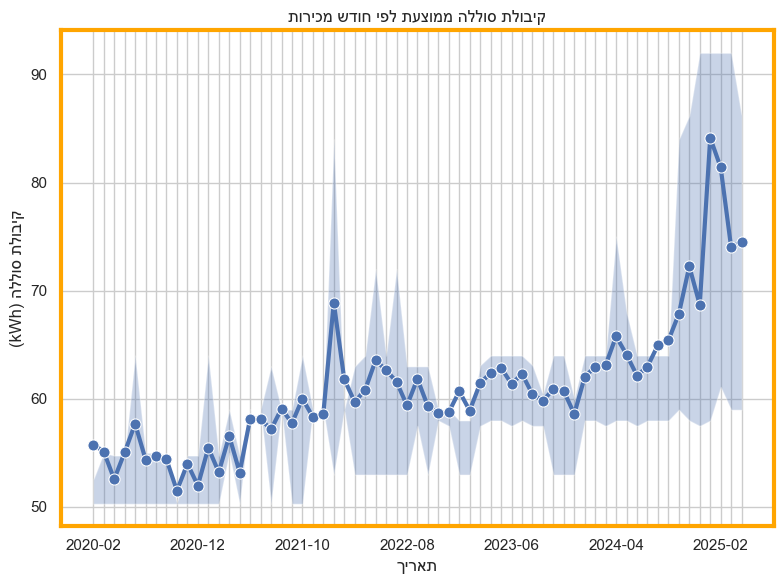

In [46]:
plot_elec_properties(elec_capacity, 'capacity', 'קיבולת סוללה')

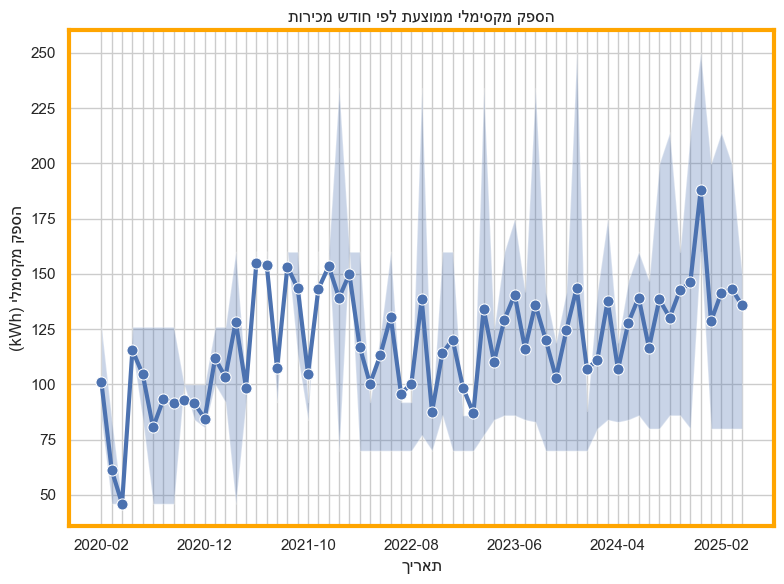

In [47]:
plot_elec_properties(elec_capacity, 'max_power', 'הספק מקסימלי')


In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Plot the smoothed mean capacity over time with width 3
ax=sns.lineplot(x='time', y='total_capacity', data=df.query('time > "2021-06"'), linewidth=3, marker='o', markersize=8)

plt.title(rev("קיבולת סוללה כוללת נמכרת בישראל לחודש"))
plt.xlabel(rev('תאריך'))
plt.ylabel('(MWh) ' + rev('קיבולת'))
sparsify_xticks(ax, 8)
nice_border()

# Scale down Y-axis values and ticks by a factor of 1/1000
y_formatter = ticker.FuncFormatter(lambda x, pos: f'{x/1000:.0f}')
plt.gca().yaxis.set_major_formatter(y_formatter)

plt.tight_layout()  # Adjust layout for better spacing

plt.show()

In [ ]:
# popular models
model='kinuy_mishari'
pop_models=elec_cars[model].value_counts().head(10).index.to_list()
#elec_cars['time'].value_counts().sort_index(ascending=False).head(10)

In [ ]:
# count model sales over time
df = elec_cars.query('kinuy_mishari in @pop_models')
count_df = df.groupby(['time', 'kinuy_mishari']).size().unstack()
#count_df = count_df.div(count_df.sum(axis=1), axis=0)

pop_models

In [ ]:
count_df.query('time > "2022-10"').plot(kind='bar', stacked=True, figsize=(12, 7))
plt.legend(loc='lower left', bbox_to_anchor=(0, 0), ncol=2)
plt.title(rev('מכירות דגמי רכב חשמלי בישראל לפי חודש'))
plt.show()

In [ ]:
elec_cars.query("time == '2025-04'")[model].value_counts().head(10)

In [ ]:
count_df = cars.groupby(['time', 'sug_delek_nm']).size().unstack()
count_df = count_df.div(count_df.sum(axis=1), axis=0)

In [ ]:
count_df

In [ ]:
sns.lineplot(data=count_df.query('time > "2022-10"'))